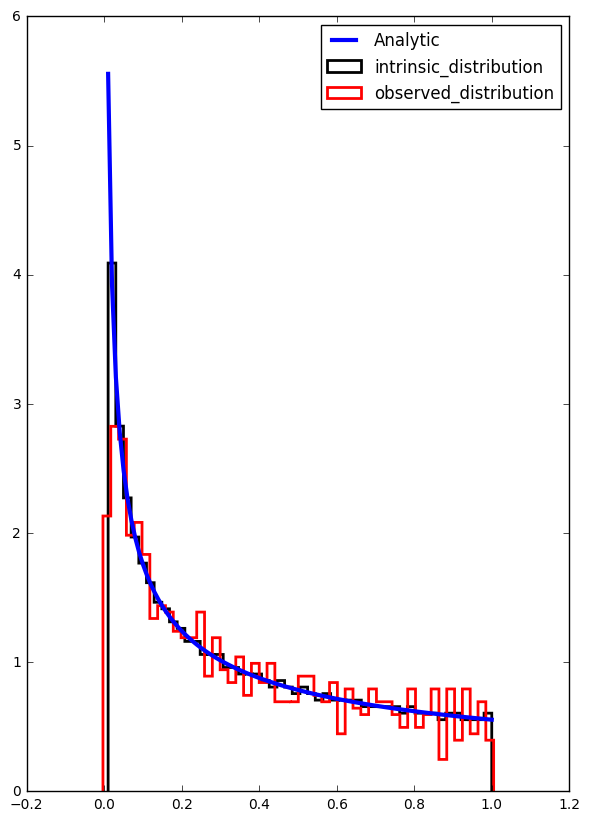

In [1]:
#-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-#
import numpy as np                                                                    # 
from matplotlib import pyplot as plt                                                  #
from scipy import stats                                                               #
from astroML.stats.random import trunc_exp                                            #
from astroML.plotting import setup_text_plots                                         #
from scipy import integrate                                                           #
#-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-#

#-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-#
#                      STEP 1 - CREATE OUR DISTRIBUTION                               #
Npoints=1000                                                                        #
b, a = 1., 2
xmin=0.1; xmax=1.#
# NOTE: This is *not* the same as drawing random values according to power law with exponent a
x=np.linspace(xmin, xmax, Npoints)  
intrinsic_distribution = b * x ** (a)
# 
# NOTE: If you do want to draw random values according to power law with exponent a use the code below
# 
# norm_factor = (a+1) * (1.0/(xmax**(a+1) - 0.01**(a+1)))
# x = ( (np.random.uniform(size=size))**(a+1.0) * (a+1) / norm_factor + dist_min**(a+1.0) )**(1.0/(a+1.0))
# 
# I have not checked the above equation. You will want to do that before using it.
# 
# END NOTE
#
#                     STEP 2 - CREATE OUR MOCK DATA                                   #
sigma=0.2                                                                             #
observed_distribution = intrinsic_distribution + np.random.normal(loc=0., scale=sigma, size=Npoints)/20.
fig, ax= plt.subplots(figsize=(7, 10))                                                #
bins=np.linspace(min(x), max(x), 50)                                                  #
ax.hist(intrinsic_distribution, histtype='step', color='k', normed=True, linewidth=2., bins=50,label="intrinsic_distribution")    #

# Plot analytic
xmin = 0.01
tmp_x = np.linspace(xmin, xmax, 100)
alpha = -0.5
norm_factor = (alpha+1) * (1.0/(xmax**(alpha+1) - 0.01**(alpha+1)))
ax.plot(tmp_x, norm_factor*tmp_x**alpha, linewidth=3.0, label = 'Analytic')

ax.hist(observed_distribution, histtype='step', color='r', normed=True, linewidth=2., bins=50,label="observed_distribution") 
ax.legend()#
plt.show()                                                                            #
#-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-#



In [2]:
#-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-#
#                     STEP 3 - CALCULATE THE LIKELIHOOD                               #
#                                                                                     #
#                         P(D|M)  *  P(M)                                             #
#              P (M|D) = ------------------                                           #
#                               P(D)                                                  #
#                                                                                     #
#    * P(M) = prior                                                                   #
#    * P(D|M) - likelihood                                                            #
#                                                                                     #
#                           WHAT IS THE LIKELIHOOD?                                   #
#                                                                                     #
#      P(D|M) = S h(x')*e(x-x')dx' = S (analytical_function)*(errors) =>              #
#                                  = S b*x^a * exp(-(x-x')^2/(2*sigma^2))dx'          #
#                                                                                     #
def power_law_dist(a, x):
    
    # NOTE: The normalization factor should include xmin as well as xmax
    norm_factor = (a+1) * (1.0/(xmax**(a+1) - xmin**(a+1)))
    return norm_factor * x**a

def integral(xprime, xobs, a, sigma):  
    
    
#     print(power_law_dist(a, xprime), np.exp(-(xobs-xprime)**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi)))

    # NOTE: we use "xprime" not "x" in the power law
    return power_law_dist(a, xprime) * np.exp(-(xobs-xprime)**2
                                    /(2*sigma**2))/(sigma*np.sqrt(2*np.pi))
#
#                                                                                     #
#        
#
def calcLikelihood(a, xobs, sigma):                
                                                                                      #
    LikelihoodProduct=[]                                                              #
    
    #
    for i in range (0, len(xobs)):  
                                                                                              #
        Likelihood_point, error_point = integrate.quad(integral, xmin
                                                       , xmax
                                                       , args=(xobs[i], a, sigma))
                                                                                      #
        LikelihoodProduct.append((Likelihood_point))       #
                                                                                      #
    LikelihoodProduct=np.array(LikelihoodProduct)                                     #
                                                                                      #
    LikelihoodProduct=np.log(LikelihoodProduct)    
    
#     plt.plot(LikelihoodProduct)
    
    #print LikelihoodProduct
                                                                                      #
    # NOTE: Since we have already taken the log here, we need to add, not multiply the individual likelihoods
    return np.sum(LikelihoodProduct)

#
                               #
def prior(a):                                                                      #
    #   For a flat distribution  #                                                    #
    # NOTE: This is "or" not "and." Also, since we are actually working with the log prior, we return either 0 or -infty
    if a>100. or a<-0.999:                                                            #
        return -np.inf                                                                #
    else:                                                                             #
        return 0.                                                                     #
                                                                                      #
def multiply(a, xobs, sigma):                                            #

    ll = calcLikelihood(a, xobs, sigma)
    lp = prior(a)

    # NOTE: You need to return the *negative* of the posterior, because this is minimized
    return -(ll+lp) 

plt.show()    

In [34]:
from scipy import optimize
from scipy.optimize import fmin,leastsq,fminbound,basinhopping

xin = -0.1  # Start it off in the wrong place to see if it recovers the input value
bounds = ((-0.99, 100.0),)
xopt = optimize.minimize(multiply, xin, args=(observed_distribution, sigma), method='TNC', bounds=bounds)

if xopt.success:
    print("Optimization successful. Power law exponent:", xopt.x)
else:
    print("Optimization failed.")

Optimization successful. Power law exponent: [-0.49842787]
